In [1]:
import os
import glob
import shutil

import scipy.fftpack
import numpy
from numpy import array
from PIL import Image, ImageDraw
from IPython.display import display, Image as DImage

ncc_mode = True

string_mode = True
input_address = 'test.png'
top = 3
empty_threshold = 20
threshold = 3
delete_threshold = 200
bin_ratio = 600


examples_path = os.getcwd() + '/examples/'
binary_path = os.getcwd() + '/binary/'
found_path = os.getcwd() + '/found/'
cutted_path = os.getcwd() + '/cutted/'

bin_examples = []
names = []
nccors = []
results = []

RESULT = ''

In [2]:
#input_address = input('Input image address:') #input must be in "" ("test.jpg" if file is in project folder),
                                              #acceptable formats: .jpg, .jpeg, .png, .gif, .bmp

In [3]:
def create_folders():
    if not os.path.exists(os.getcwd() + '/examples/'):
        os.mkdir('examples')

    if not os.path.exists(os.getcwd() + '/binary/'):
        os.mkdir('binary')

    if not os.path.exists(os.getcwd() + '/found/'):
        os.mkdir('found')
    
    if not os.path.exists(os.getcwd() + '/cutted/'):
        os.mkdir('cutted')

    for d, dirs, files in os.walk(examples_path):
            for f in dirs:
                if not os.path.exists(binary_path + f):
                    os.mkdir(binary_path+ f)
                    os.mkdir(cutted_path+ f)

In [4]:
def clean_folders():              
    if os.path.exists(os.getcwd() + '/binary/'):   
        shutil.rmtree(os.getcwd() + '/binary/')
    
    if os.path.exists(os.getcwd() + '/found/'):
        shutil.rmtree(os.getcwd() + '/found/')
        
    if os.path.exists(os.getcwd() + '/cutted/'):
        shutil.rmtree(os.getcwd() + '/cutted/')

In [5]:
def address_helper(addr, mode):
    if mode == 'png': #after preprocessing the program only works with .png
        addr = addr.replace('.jpg', '.png')
        addr = addr.replace('.jpeg', '.png')
        addr = addr.replace('.gif', '.png')
        addr = addr.replace('.bmp', '.bmp')
        
    if mode == 'bin': #change the address of the folder to /binary
        addr = addr.replace('/examples/', '/binary/')
        
    if mode == 'cln': #leave only the name of file (letter)
        addr = addr.replace('.jpg', '')
        addr = addr.replace('.jpeg', '')
        addr = addr.replace('.gif', '')
        addr = addr.replace('.png', '')
        addr = addr.replace('.bmp', '')
        addr = addr.replace(binary_path, '')
        addr = addr.replace(found_path, '')
        addr = addr.replace(cutted_path, '')
    
    return addr

In [6]:
def binarization(input_img_addr):
    input_image  = Image.open(input_img_addr).convert('RGBA') #convert for .gif opening fix
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b, a = input_image.getpixel((i, j))
            if a == 0:
                r, g, b = 0, 0, 0
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255
            else:
                r, g, b = 0, 0, 0 
            draw.point((i, j), (r, g, b))
    del draw
    
    input_img_addr = address_helper(input_img_addr, 'png')
    input_image.save(address_helper(input_img_addr, 'bin'), "PNG")

In [7]:
def separation(input_img_addr, threshold, empty_threshold):
    x0 = 0
    y0 = 0
    x1 = 0
    y1 = 0

    symbolsx = []
    symbolsy = []

    black = 0
    symbol = False
    empty = 0
    
    input_image = Image.open(input_img_addr).convert('L')
    
    for x in range(input_image.size[0]):
        for y in range(input_image.size[1]):
            pix = input_image.getpixel((x, y))
            if pix < 255:
                black += 1
        if symbol == True and black < threshold:
            empty += 1
        if symbol == False and black > threshold: 
            x0 = x
            symbol = True
        if symbol == True and black <= threshold and empty >= empty_threshold:
            x1 = x
            symbol = False
            symbolsx.append((x0, x1))
            empty = 0
        black = 0
    
    
    black = 0
    symbol = False
    
    if string_mode:
        for y in range(input_image.size[1]):
            for x in range(input_image.size[0]):
                pix = input_image.getpixel((x, y))
                if pix < 255:
                    black += 1
            if symbol == True and black < threshold:
                empty += 1
            if symbol == False and black > threshold:
                y0 = y
                symbol = True
            if symbol == True and black <= threshold and empty >= empty_threshold:
                y1 = y
                symbol = False
                symbolsy.append((y0, y1))
                empty = 0
            black = 0
    
    count = 0
    black = 0
    
    if symbolsx == []:
        symbolsx = [(0, input_image.size[0])] 
    if symbolsy == []:
        symbolsy = [(0, input_image.size[1])] 
        
    for y in symbolsy:
        for x in symbolsx:
            if count < 1000:
                temp = '{:03d}'.format(count)
                addr = 'found/' + str(temp) + '.png'
                input_image.crop((x[0], y[0], x[1], y[1])).save(addr, "PNG")
            count += 1

In [8]:
def delete_trash(threshold):
    images = os.listdir(found_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(found_path + images[i])
            
            for x in range(input_image.size[0]):
                for y in range(input_image.size[1]):
                    pix = input_image.getpixel((x, y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(found_path + images[i])
        except IOError:
            pass        

In [9]:
def ncc(input_img_addr, example_addr): 
    input_image = Image.open(input_img_addr)
    example = Image.open(example_addr).resize((input_image.size[0],
                                               input_image.size[1]), 
                                              Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(numpy.mean(pixel))
        vectors.append(vector)
        norms.append(numpy.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = numpy.dot(a / a_norm, b / b_norm)
    return res

In [10]:
def compare_1to1(input_img_addr, example_addr):
    input_img_addr = found_path + input_img_addr
    naive_cut(input_img_addr)

    if ncc_mode:
        nccors.append(ncc(input_img_addr, example_addr))
    
    names.append(address_helper(example_addr, 'cln')) 

In [11]:
def compare_1toN(input_img_addr):
    global names, nccors, bin_examples
    names, nccors = [], []
    
    for i in range(len(bin_examples)):
        try:
            compare_1to1(input_img_addr, bin_examples[i])
        except IOError:
            pass

In [12]:
def result_1toN():
    global results
    global RESULT
    results = []
    
    if ncc_mode and nccors != []:
        results.append(names[nccors.index(max(nccors))])
    
    if results == []:
        results = ['']
        
    temp = max(set(results), key=results.count)
    display(DImage(filename=binary_path + temp + '.png'))
    for d, dirs, files in os.walk(examples_path):
        for f in dirs:
            temp = temp.replace(f, '')
            temp = temp.replace('/', '')  
    RESULT += temp 

In [13]:
def print_full(top, tmp_arr, flag):
    for i in range(top):
        if flag == 'max':
            tmp = max(tmp_arr)
        if flag == 'min':
            tmp = min(tmp_arr)    
        print(str(i+1)+". :"+str(names[tmp_arr.index(max(tmp_arr))])+" scores: "+str(max(tmp_arr)))
        tmp_arr.remove(max(tmp_arr))

In [14]:
def print_1toN():
    global top
    print('Results:')
    if ncc_mode and nccors != []:
        print('NCC mode:')
        print_full(top, nccors, 'max')
    print('Result:' + str(RESULT))

In [15]:
def naive_cut(img_address):
    img = Image.open(img_address).convert('L')
    arr = array(img)
    norm_arr = []
    find = False

    for c in range(4):
        black = 0
        find = False
        img = Image.fromarray(arr)
        for x in range(len(arr[:, 1])):
            if find:
                break
            for y in range(len(arr[1, :])):
                if arr[x, y] == 0:
                    black += 1
            if black >= 1:
                arr = numpy.delete(arr, numpy.s_[0:x], axis=0)
                find = True
                break
        arr = numpy.rot90(arr)
        c+=1
        
    
    img = Image.fromarray(arr)
    img.save(img_address.replace('binary', 'cutted'),"PNG")

In [16]:
def found_symbols():
    symbols = os.listdir(found_path)
    print('Found:')
    for i in sorted(symbols):
        try:
            display(DImage(filename=found_path + i))
        except IOError:
            pass

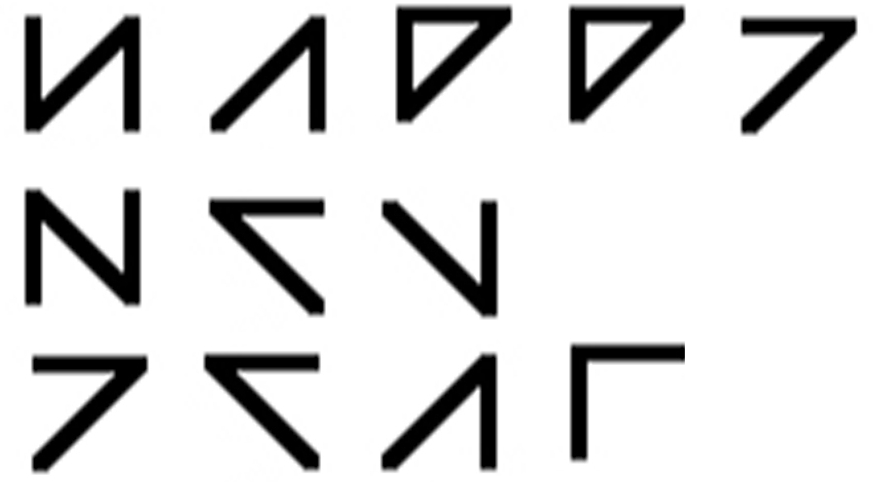

Processing:


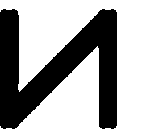

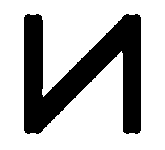

Results:
NCC mode:
1. :1/h scores: 1.0
2. :1/v scores: 0.892544964015
3. :1/s scores: 0.884280543409
Result:h
Processed: 1/12
Processing:


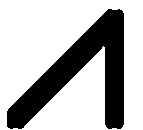

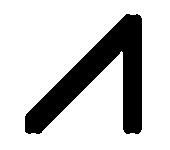

Results:
NCC mode:
1. :1/a scores: 1.0
2. :1/d scores: 0.899117668128
3. :1/s scores: 0.884280543409
Result:ha
Processed: 2/12
Processing:


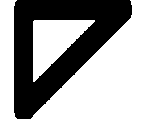

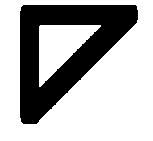

Results:
NCC mode:
1. :1/p scores: 1.0
2. :1/v scores: 0.9056385886
3. :1/y scores: 0.904127851764
Result:hap
Processed: 3/12
Processing:


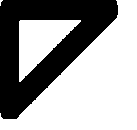

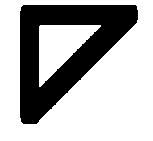

Results:
NCC mode:
1. :1/p scores: 1.0
2. :1/v scores: 0.9056385886
3. :1/y scores: 0.904127851764
Result:happ
Processed: 4/12
Processing:


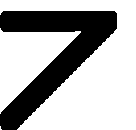

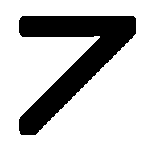

Results:
NCC mode:
1. :1/y scores: 1.0
2. :1/e scores: 0.904696747481
3. :1/p scores: 0.883355618608
Result:happy
Processed: 5/12
Processing:


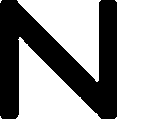

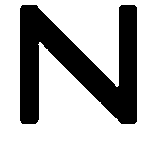

Results:
NCC mode:
1. :1/n scores: 1.0
2. :1/f scores: 0.894513489705
3. :1/d scores: 0.893057455235
Result:happyn
Processed: 6/12
Processing:


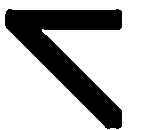

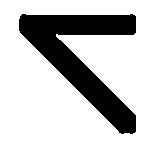

Results:
NCC mode:
1. :1/e scores: 1.0
2. :1/o scores: 0.909088542749
3. :1/r scores: 0.871875557438
Result:happyne
Processed: 7/12
Processing:


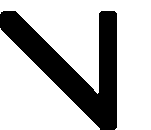

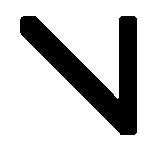

Results:
NCC mode:
1. :1/w scores: 1.0
2. :1/o scores: 0.906261755787
3. :1/d scores: 0.893057455235
Result:happynew
Processed: 8/12
Processing:


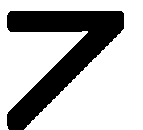

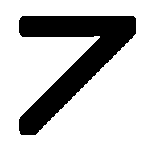

Results:
NCC mode:
1. :1/y scores: 1.0
2. :1/e scores: 0.904696747481
3. :1/p scores: 0.883355618608
Result:happynewy
Processed: 9/12
Processing:


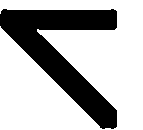

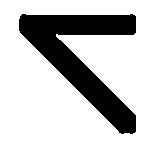

Results:
NCC mode:
1. :1/e scores: 1.0
2. :1/o scores: 0.909088542749
3. :1/r scores: 0.871875557438
Result:happynewye
Processed: 10/12
Processing:


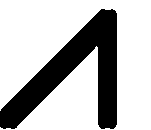

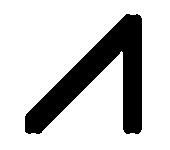

Results:
NCC mode:
1. :1/a scores: 1.0
2. :1/d scores: 0.899117668128
3. :1/s scores: 0.884280543409
Result:happynewyea
Processed: 11/12
Processing:


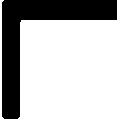

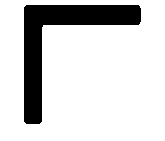

Results:
NCC mode:
1. :1/r scores: 0.999200377887
2. :1/m scores: 0.902727767146
3. :1/w scores: 0.881871787936
Result:happynewyear
Processed: 12/12
Message: happynewyear


In [17]:
def main():
    global RESULT, input_address, empty_threshold
    RESULT = ''
    clean_folders()
    create_folders()
    display(DImage(filename=input_address))
    binarization(input_address)
    input_address = address_helper(input_address, 'png')
    
    examples = []
    for d, dirs, files in os.walk(examples_path):
        for f in files:
            path = os.path.join(d, f)
            examples.append(path)
             
    for i in range(len(examples)):
        try:
            binarization(examples[i])
            naive_cut(address_helper(examples[i], 'bin'))
        except IOError:
            pass
    
    global bin_examples
    for d, dirs, files in os.walk(cutted_path):
        for f in files:
            path = os.path.join(d, f)
            bin_examples.append(path)
            
   
    separation(input_address, threshold, empty_threshold)
    delete_trash(delete_threshold)
    #found_symbols()
        
    symbols = os.listdir(found_path)
    count = 0 
    for i in sorted(symbols):
        try:
            count += 1
            print('Processing:')
            display(DImage(filename=found_path + i))
            compare_1toN(i)
            result_1toN()
            print_1toN()
            print('Processed: ' + str(count) + '/' + str(len(symbols)))
        except IOError:
            pass
    print('Message: ' + RESULT)
    RESULT = ''
    clean_folders()
main()